<a href="https://colab.research.google.com/github/lkforward/flower/blob/simple_model_class/run_cloud_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!pip install catalyst
!pip install pretrainedmodels
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install pytorch_toolbelt
!pip install torchvision==0.4
!pip install albumentations==0.3.2

In [20]:
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ../input/apex-325f5a0/apex-master/
from apex import amp

/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-kyjmpwn9
Created temporary directory: /tmp/pip-req-tracker-1abqj659
Created requirements tracker '/tmp/pip-req-tracker-1abqj659'
Created temporary directory: /tmp/pip-install-9cmlbv1m
Cleaning up...
Removed build tracker '/tmp/pip-req-tracker-1abqj659'
ERROR: Invalid requirement: '../input/apex-325f5a0/apex-master/'
Hint: It looks like a path. File '../input/apex-325f5a0/apex-master/' does not exist.
Exception information:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/packaging/requirements.py", line 93, in __init__
    req = REQUIREMENT.parseString(requirement_string)
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/pyparsing.py", line

ModuleNotFoundError: ignored

In [25]:
import os
os.listdir("../")

!mkdir ../input/apex

['sys',
 'lib',
 'usr',
 'opt',
 'root',
 'run',
 'proc',
 'srv',
 'dev',
 'bin',
 'media',
 'home',
 'etc',
 'sbin',
 'tmp',
 'lib64',
 'mnt',
 'boot',
 'var',
 'input',
 'content',
 '.dockerenv',
 'tensorflow-2.0.0',
 'tools',
 'datalab',
 'swift',
 'lib32']

In [40]:
# !git clone https://github.com/NVIDIA/apex
# !cd apex
# !mv apex /content/gdrive/My\ Drive/kaggle_cloud/
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" /content/gdrive/My\ Drive/kaggle_cloud/apex

/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-lg9j20l1
Created temporary directory: /tmp/pip-req-tracker-_murhow2
Created requirements tracker '/tmp/pip-req-tracker-_murhow2'
Created temporary directory: /tmp/pip-install-i54s6oo5
Processing ./gdrive/My Drive/kaggle_cloud/apex
  Created temporary directory: /tmp/pip-req-build-hjwr0ahm
  Added file:///content/gdrive/My%20Drive/kaggle_cloud/apex to build tracker '/tmp/pip-req-tracker-_murhow2'
    Running setup.py (path:/tmp/pip-req-build-hjwr0ahm/setup.py) egg_info for package from file:///content/gdrive/My%20Drive/kaggle_cloud/apex
    Running command python setup.py egg_info
    torch.__version__  =  1.2.0
    running egg_info
    creating /tmp/pip-req-build-hjwr0ahm/pip-egg-info/apex.egg

In [35]:
# !cd ../input
!pwd
!ls apex 

/content
apex  docs	LICENSE    requirements.txt  tests
csrc  examples	README.md  setup.py


In [0]:
import os
import cv2
import collections
import time 
import tqdm
from PIL import Image
from functools import partial
train_on_gpu = True

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
from albumentations import torch as AT

import gc

In [0]:
from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from catalyst.dl.runner import SupervisedRunner
from catalyst.contrib.models.segmentation import Unet
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback

import segmentation_models_pytorch as smp

# Mount the google drive

In [5]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [6]:
!pwd

/content


# Helper Functions



In [0]:
def get_img(x, folder: str='train_images'):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{path}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
    """
    Create mask based on df, image name and shape.

    [OUTPUTS]:
    masks: an array with shape (shape[0], shape[1], 4).
      Mask for each class labels.
    """
    encoded_masks = df.loc[df['im_id'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)

    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :, idx] = mask
            
    return masks


def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')


def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
                
        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)
        
        
        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)
            
            
def visualize_with_raw(image, mask, original_image=None, original_mask=None, raw_image=None, raw_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)


    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(raw_mask[:, :, i])
        ax[1, i + 1].set_title(f'Raw predicted mask {class_dict[i]}', fontsize=fontsize)
        
    ax[2, 0].imshow(image)
    ax[2, 0].set_title('Transformed image', fontsize=fontsize)


    for i in range(4):
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(f'Predicted mask with processing {class_dict[i]}', fontsize=fontsize)
            
            
def plot_with_augmentation(image, mask, augment):
    """
    Wrapper for `visualize` function.
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented['image']
    mask_flipped = augmented['mask']
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)

  
    
sigmoid = lambda x: 1 / (1 + np.exp(-x))


def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    # don't remember where I saw it
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num


def get_training_augmentation():
    """
    Define the preprocessing for the training data. 
    """
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        albu.GridDistortion(p=0.5),
        albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
        albu.Resize(320, 640)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(320, 640)
    ]
    return albu.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.augmentations.transforms.Lambda(image=preprocessing_fn),
        albu.augmentations.transforms.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2. * intersection.sum() / (img1.sum() + img2.sum())

In [0]:
path = '/content/gdrive/My Drive/kaggle_cloud/data'


def get_data(path, n_samples=None):
  """
  Read the taining data information, including image id and labels. 
  """
  train = pd.read_csv(f'{path}/train.csv')
  sub = pd.read_csv(f'{path}/sample_submission.csv')
  print("Reading the training csv...")
  print(train.columns)
  print(train.shape)

  n_train = len(os.listdir(f'{path}/train_images'))
  print("Reading the training images...")
  print(f'There are {n_train} images in the original train dataset')

  if n_samples: 
    train = train.iloc[:n_samples, :]
    print(f'Use {n_samples} images within the training dataset.')


  train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
  train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

  sub['label'] = sub['Image_Label'].apply(lambda x: x.split('_')[1])
  sub['im_id'] = sub['Image_Label'].apply(lambda x: x.split('_')[0])

  return train, sub


def display_images_with_masks(path, train):
  """
  Randomly choose 4 images from the training dataset, and plot them with the masks.
  """

  fig = plt.figure(figsize=(25, 16))
  for j, im_id in enumerate(np.random.choice(train['im_id'].unique(), 4)):
      for i, (idx, row) in enumerate(train.loc[train['im_id'] == im_id].iterrows()):
          ax = fig.add_subplot(5, 4, j * 4 + i + 1, xticks=[], yticks=[])
          im = Image.open(f"{path}/train_images/{row['Image_Label'].split('_')[0]}")
          plt.imshow(im)
          mask_rle = row['EncodedPixels']
          try: # label might not be there!
              mask = rle_decode(mask_rle)
          except:
              mask = np.zeros((1400, 2100))
          plt.imshow(mask, alpha=0.5, cmap='gray')
          ax.set_title(f"Image: {row['Image_Label'].split('_')[0]}. Label: {row['label']}")


def split_data(train, sub):
  """
  Split the training dataset into train/valid datasets, and use all the data in 
  the submission dataset as test data. 

  [OUTPUTS]:
  train_ids/valid_ids/test_ids: array of image ids(str). 
  """
  train_labels = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label']
  id_mask_count = train_labels.apply(lambda x: x.split('_')[0]).value_counts()
  id_mask_count = id_mask_count.reset_index().rename(columns={'index': 'img_id', 'Image_Label': 'count'})
  train_ids, valid_ids = train_test_split(id_mask_count['img_id'].values,
                                          random_state=42,
                                          stratify=id_mask_count['count'],
                                          test_size=0.1)
 
  # Alternatively, we can use sub['im_id'] directly. 
  test_ids = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values
  
  return train_ids, valid_ids, test_ids


class CloudDataset(Dataset):
    def __init__(self, df: pd.DataFrame = None, datatype: str = 'train', img_ids: np.array = None,
                 transforms = albu.Compose([albu.HorizontalFlip(),AT.ToTensor()]),
                 preprocessing=None):
        """
        [INPUTS]:
        df: a pandas dataframe. 
          The image information dataframe, obtained from function "get_data()".
        datatype: string. 
          Whether it is 'train' or 'test'. 
        
        """
        self.df = df
        if datatype != 'test':
            self.data_folder = f"{path}/train_images"
        else:
            self.data_folder = f"{path}/test_images"
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        if self.preprocessing:
            preprocessed = self.preprocessing(image=img, mask=mask)
            img = preprocessed['image']
            mask = preprocessed['mask']
        return img, mask

    def __len__(self):
        return len(self.img_ids)

# Load Dataset

In [9]:
train, sub = get_data(path)

Reading the training csv...
Index(['Image_Label', 'EncodedPixels'], dtype='object')
(22184, 2)
Reading the training images...
There are 5546 images in the original train dataset


In [10]:
print(train.shape)
train.head()

(22184, 4)


,Image_Label,EncodedPixels,label,im_id
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,Fish,0011165.jpg
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,Flower,0011165.jpg
2,0011165.jpg_Gravel,NaN,Gravel,0011165.jpg
3,0011165.jpg_Sugar,NaN,Sugar,0011165.jpg
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,Fish,002be4f.jpg


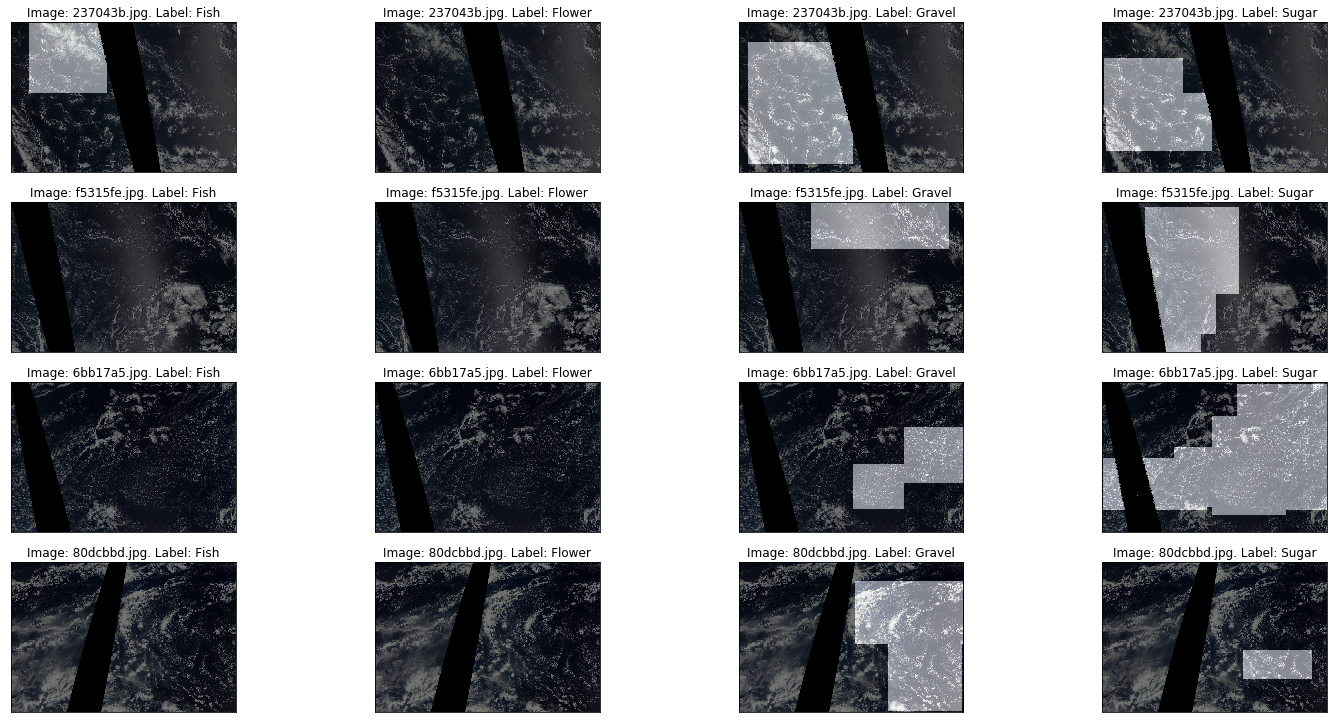

In [11]:
display_images_with_masks(path, train)

In [12]:
train_ids, valid_ids, test_ids = split_data(train, sub)

print('The size of training sample:', train_ids.shape)
print('The size of validation sample:', valid_ids.shape)
print('The size of testing sample:', test_ids.shape)

The size of training sample: (4991,)
The size of validation sample: (555,)
The size of testing sample: (3698,)


# Make a Model Class for Easy Set-up

In [0]:
def plot_metrics_json(metric_file, metric_name, n_epochs, do_save_fig=False, figname=None):
  """
  Plot the change of a metric in the training process saved in a *.json file.

  metric_name: str. 
    The name of the metric variable. Choose from: '_base/lr', 'dice', 'loss'. 
  """

  with open(metric_file, 'r') as fm: 
    metrics = json.load(fm)

    metric_hist = []
    for i in range(n_epochs):
      metric_i = metrics['epoch_{}'.format(i)][2][metric_name]
      metric_hist.append(metric_i)

  plt.plot(range(n_epochs), metric_hist)
  plt.xlabel('Epochs')
  plt.ylabel(metric_name)

  if do_save_fig:
    if not figname:
      figname = metric_file.replace('_metrics.json', metric_name + '.png')
      print(figname)
    plt.savefig(figname)

In [0]:
DEVICE = 'cuda'

class CloudSeg(object):
  def __init__(self, data_path, batch_size, ENCODER = 'resnet50', ENCODER_WEIGHTS = 'imagenet'):

    path = data_path
    train, sub = get_data(path)
    self.train_ids, self.valid_ids, self.test_ids = split_data(train, sub)

    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
    num_workers = 0
    # bs = 16
    self.train_dataset = CloudDataset(df=train, datatype='train', 
                                      img_ids=self.train_ids, 
                                      transforms = get_training_augmentation(), 
                                      preprocessing=get_preprocessing(preprocessing_fn))

    self.valid_dataset = CloudDataset(df=train, datatype='valid', 
                                      img_ids=self.valid_ids, 
                                      transforms = get_validation_augmentation(), 
                                      preprocessing=get_preprocessing(preprocessing_fn))

    self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True, 
                                   num_workers=num_workers)
    self.valid_loader = DataLoader(self.valid_dataset, batch_size=batch_size, shuffle=False, 
                                   num_workers=num_workers)

    self.loaders = {
        "train": self.train_loader,
        "valid": self.valid_loader
    }

    # model, criterion, optimizer
    ACTIVATION = None
    self.model = smp.Unet(encoder_name=ENCODER, 
                          encoder_weights=ENCODER_WEIGHTS, 
                          classes=4, 
                          activation=ACTIVATION,
    )

    self.optimizer = torch.optim.Adam([
        {'params': self.model.decoder.parameters(), 'lr': 1e-2}, 
        {'params': self.model.encoder.parameters(), 'lr': 1e-3},  
    ])

    opt_level = 'O1'
    self.model.cuda()
    self.model, self.optimizer = amp.initialize(self.model, self.optimizer, 
                                                opt_level=opt_level)

    self.scheduler = ReduceLROnPlateau(self.optimizer, factor=0.15, patience=2)
    self.criterion = smp.utils.losses.BCEDiceLoss(eps=1.)
    self.runner = SupervisedRunner()

    pass

  def train(self, num_epochs, logdir, save_metric_plots=False):
    runner = self.runner
    runner.train(model=self.model, 
                 criterion=self.criterion,
                 optimizer=self.optimizer,
                 scheduler=self.scheduler,
                 loaders=self.loaders,
                 callbacks=[DiceCallback(), EarlyStoppingCallback(patience=5, min_delta=0.001)],
                 logdir=logdir,
                 num_epochs=num_epochs,
                 verbose=True)
    
    if save_metric_plot:
      metric_file = logdir + 'checkpoints/_metrics.json'
      metric_list = ['loss', 'dice']
      for metric_name in metric_list:
        plot_metrics_json(metric_file, metric_name, num_epochs, do_save_fig=True, figname=None)
    pass

  def predict(self):
    pass

In [0]:
# data_path = '/content/gdrive/My Drive/kaggle_cloud/data'
# batch_size = 16

# ENCODER = 'resnet50'
# ENCODER_WEIGHTS = 'imagenet'

# # logdir = '/content/gdrive/My Drive/kaggle_cloud/run_log'
# # num_epochs = 19
# num_epochs=1
# logdir = '/content/gdrive/My Drive/kaggle_cloud/run_log1110'

In [0]:
# num_epochs=1
# logdir = '/content/gdrive/My Drive/kaggle_cloud/run_log1110'
# cloud_model.train(num_epochs, logdir, save_metric_plots=False)

In [42]:
data_path = '/content/gdrive/My Drive/kaggle_cloud/data'
batch_size = 16
# encoder_list = ['inceptionresnetv2', 'resnext50_32x4d', 'se_resnet50']
encoder_list = ['resnet50', 'resnext50_32x4d', 'se_resnet50']

for encoder in encoder_list:
  cloud_model = CloudSeg(data_path, batch_size, ENCODER = encoder, ENCODER_WEIGHTS = 'imagenet')
  num_epochs=19
  logdir = '/content/gdrive/My Drive/kaggle_cloud/log_' + encoder
  cloud_model.train(num_epochs, logdir, save_metric_plots=True)

  del cloud_model
  torch.cuda.empty_cache()
  gc.collect()

Reading the training csv...
Index(['Image_Label', 'EncodedPixels'], dtype='object')
(22184, 2)
Reading the training images...
There are 5546 images in the original train dataset


/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2247: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



RuntimeError: ignored